https://github.com/FinanceData/FinanceDataReader

In [50]:
import json
import datetime
import time
import pandas as pd
from pandas import json_normalize
import plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
import FinanceDataReader as fdr
import decimal
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from requests_html import HTMLSession
session = HTMLSession()

In [2]:
import gsheets
# pip install google-api-python-client
# pip install google-auth-oauthlib

In [92]:
def str_to_timestamp(date):
    obj_datetime = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return datetime_to_timestamp(obj_datetime)

def datetime_to_timestamp(dt):
    return int(time.mktime(dt.timetuple()))

def transform_ohlc(data):
    result = {}
    if 't' in data.keys():
        result['Date'] = data.pop('t')
        for i, v in enumerate(result['Date']):
            result['Date'][i] = datetime.datetime.fromtimestamp(v)
    if 'o' in data.keys():
        result['Open'] = data.pop('o')
    if 'h' in data.keys():
        result['High'] = data.pop('h')
    if 'l' in data.keys():
        result['Low'] = data.pop('l')
    if 'c' in data.keys():
        result['Close'] = data.pop('c')
    if 'v' in data.keys():
        result['Volume'] = data.pop('v')
        
    df = pd.DataFrame.from_dict(result)
    return df.set_index('Date')


host = 'https://tvc4.forexpros.com/bf9b0cf35ce6ca91b1bba8dd1d70c0c2/1601606035/18/18/88/'

def history(symbol, resolution, from_date, to_date=None):
    from_timestamp = str_to_timestamp(from_date + ' 00:00:00' if len(from_date) == 10 else from_date)
    if not to_date:
        to_timestamp = datetime_to_timestamp(datetime.datetime.now())
    else:     
        to_timestamp = str_to_timestamp(to_date + ' 23:59:59' if len(to_date) == 10 else to_date)
 
    data = history_raw(symbol, resolution, from_timestamp, to_timestamp)
    if len(data['t']) >= 5000:
        while True:
            data2 = history_raw(symbol, resolution, data['t'][-1] + 1, to_timestamp)
            data['t'] = data['t'] + data2['t']
            data['o'] = data['o'] + data2['o']
            data['h'] = data['h'] + data2['h']
            data['l'] = data['l'] + data2['l']
            data['c'] = data['c'] + data2['c']
            data['v'] = data['v'] + data2['v']
            if len(data2['t']) < 5000: break
                
    return transform_ohlc(data)

def history_raw(symbol, resolution, from_timestamp, to_timestamp):
    uri = f'history?symbol={symbol}&resolution={resolution}&from={from_timestamp}&to={to_timestamp}'
    r = session.get(host + uri)
    return json.loads(r.html.text)    

def quotes(symbols):
    symbols_text = ','.join(symbols)
    uri = f'quotes?symbols={symbols_text}'
    r = session.get(host + uri)
    data = json.loads(r.html.text)
    d = [row['v'] for row in data['d']]
    return pd.DataFrame(d)

def symbols(symbol):
    uri = f'symbols?symbol={symbol}'
    r = session.get(host + uri)
    data = json.loads(r.html.text)    
    return json_normalize(data)

def search(query, limit=30):
    uri = f'search?limit={limit}&query={query}&type=&exchange='
    r = session.get(host + uri)
    data = json.loads(r.html.text)    
    return pd.DataFrame(data)

def candle(symbol, resolution, from_date, to_date=None, digit=0):
    return candle_df(history(symbol, resolution, from_date, to_date), digit)

def candle_df(df, digit=0):
    df['Open'] = round(df['Open'], digit)
    df['High'] = round(df['High'], digit)
    df['Low'] = round(df['Low'], digit)
    df['Close'] = round(df['Close'], digit)
    df['Pre_Close'] = df['Close'].shift()
    df['Gap'] = df['Open']-df['Pre_Close']
    df['Change'] = df['Close']-df['Pre_Close']
    df['Change_Rate'] = round((df['Close']/df['Pre_Close']-1)*100, 2)
    df['Body'] = df['Close']-df['Open']
    df['Height'] = df['High']-df['Low']
    return df
    
def candlestick(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.1, 0.7])
    fig.add_trace(go.Candlestick(x=df.index.strftime("%y.%m.%d %H:%M"),
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'], showlegend=False),
               row=1, col=1)
    fig.add_trace(go.Bar(x=df.index.strftime("%y.%m.%d %H:%M"), y=df['Volume'], showlegend=False),
               row=3, col=1)
#     fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(height=700)
    fig.show()
    
def ohlc(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index.strftime("%y.%m.%d %H:%M"),
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])
#     fig.update_xaxes(
#         rangeslider_visible=True,
#         rangebreaks=[
#             # NOTE: Below values are bound (not single values), ie. hide x to y
#             dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
# #             dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
#             # dict(values=["2019-12-25", "2020-12-24"])  # hide holidays (Christmas and New Year's, etc)
#         ]
#     )    
    fig.update_layout(
#         autosize=False,
#         width=500,
        height=700
#         margin=dict(
#             l=50,
#             r=50,
#             b=100,
#             t=100,
#             pad=4
#         ),
#         paper_bgcolor="LightSteelBlue",
    )

    fig.show()    
    
def df_compare(targets, resolution, start_day, end_day=None):
    df_list = [history(target, resolution, start_day, end_day)['Close'] for target in targets]
    df = pd.concat(df_list, axis=1)
    df.columns = [codes[target]['title'] for target in targets] 
    return df

def index_chart(df):
    df_plot = df / df.iloc[0] - 1.0
    df_plot.iplot() 
    
def sheet_df(doc_id):
    data = gs.open(doc_id).sheets[0].read()
    df = pd.DataFrame(data=data.rows, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'day', 'weekday'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.astype({'Volume':'float'})
    return df

In [4]:
codes = {
    'GC': {
        'title': 'Gold',
        'type': 'Future',
        'exchange': 'COMEX'
    },
    'SI': {
        'title': 'Silver',
        'type': 'Future',
        'exchange': 'COMEX'
    },
    'HG': {
        'title': 'Copper',
        'type': 'Future',
        'exchange': 'COMEX'
    },
    'CL': {
        'title': 'Crude Oil',
        'type': 'Future',
        'exchange': 'NYMEX'
    },
    'NG': {
        'title': 'Natural Gas',
        'type': 'Future',
        'exchange': 'NYMEX'
    },
    'US30': {
        'title': 'Dow 30',
        'type': 'Future',
        'exchange': 'NYMEX'
    },
    'US500': {
        'title': 'S&P500',
        'type': 'Future',
        'exchange': 'NYMEX'
    },
    'USTEC': {
        'title': 'Nasdaq 100',
        'type': 'Future',
        'exchange': 'NYMEX'
    },
    'VX': {
        'title': 'S&P500 VIX',
        'type': 'Future',
        'exchange': 'CBOE'
    },
    'DX': {
        'title': 'Dollar Index',
        'type': 'Future',
        'exchange': 'ICE'
    },
    'USD/KRW': {
        'title': 'USD/KRW',
        'type': 'FX',
        'exchange': ''
    },
    'KS11': {
        'title': 'KOSPI',
        'type': 'Index',
        'exchange': '서울'
    },
    'KQ11': {
        'title': 'KOSDAQ',
        'type': 'Index',
        'exchange': '서울'
    },
    'JP225': {
        'title': '닛케이',
        'type': 'Index',
        'exchange': '도쿄'
    },
}
def quote_name(code):
    if codes[code]['exchange']:
        return codes[code]['exchange'] + ':' + code 
    return code

def code_title(code):
    return codes[code]['title']

In [5]:
quotes(['COMEX:GC', 'COMEX:HG', 'NYMEX:US30', 'NYMEX:US500', 'NYMEX:USTEC', 'NYMEX:DX', 
        '서울:KS11', '서울:KS100', '도쿄:JP225', 
        '서울:005930', '서울:035420', '서울:001040', 'KOSDAQ:035760', '서울:009540'])

,ch,chp,short_name,exchange,description,lp,ask,bid,spread,open_price,high_price,low_price,prev_close_price,volume
0,8.35,0.47,금,,금 선물,1783.35,"1,783.60","1,783.10",0,"1,774.95","1,790.70","1,759.15",1775.00,0
1,0.1660,4.26,구리,,구리 선물,4.0670,4.0665,4.0655,0,3.9062,4.0907,3.8862,3.9010,0
2,-6.0,-0.02,다우존스,,다우존스 30 선물,31425.0,"31,430.0","31,420.0",0,"31,445.0","31,582.5","31,303.5",31431.0,0
3,-10.50,-0.27,S&P 500,,S&P 500 선물,3899.00,"3,899.50","3,899.25",0,"3,910.38","3,930.88","3,890.38",3909.50,0
4,-60.50,-0.44,나스닥 100,,나스닥 100 선물,13572.50,"13,573.00","13,572.00",0,"13,638.50","13,728.75","13,536.88",13633.00,0
5,-0.255,-0.28,미국 달러 지수,,미국 달러 지수 선물,90.345,90.365,90.325,0,90.528,90.657,90.168,90.600,"27,096"
6,20.96,0.68,코스피지수,서울,코스피지수,3107.62,0.00,0.00,0,"3,089.96","3,109.67","3,040.28",3086.66,"3,455,504"
7,28.56,0.89,KOSPI 100,서울,KOSPI 100,3220.75,0.00,0.00,0,"3,196.84","3,223.39","3,150.22",3192.19,"125,544"
8,-218.17,-0.72,닛케이,도쿄,닛케이,30017.92,"30,016.00","30,007.00",0,"29,970.59","30,169.59","29,847.33",30017.92,0
9,500,0.61,삼성전자,서울,삼성전자,82600,"82,700","82,600",0,"82,300","82,800","81,000",82100,"25,469,274"


In [27]:
df = df_compare(['CL', 'HG', 'DX'], '60', '2021-02-03 10:00:00')
index_chart(df)

In [26]:
df

,Crude Oil,Copper,Dollar Index
Date,,,
2021-02-03 08:00:00,54.959999,3.5295,NaN
2021-02-03 09:00:00,55.060001,3.5353,NaN
2021-02-03 10:00:00,54.939999,3.5253,90.992996
2021-02-03 11:00:00,55.040001,3.5165,91.007004
2021-02-03 12:00:00,54.980000,3.5133,91.042999
...,...,...,...
2021-02-06 02:00:00,56.840000,3.6223,91.037003
2021-02-06 03:00:00,56.820000,3.6288,91.031998
2021-02-06 04:00:00,56.939999,3.6320,91.028000


In [36]:
df = candle('HG', '60', '2021-01-01', digit=2)
candle_chart(df)

In [9]:
df = history('HG', '60', '2021-01-02')
df['Close'].iplot(kind='line')

In [5]:
지수 = ['KS:KS11', 'KS:KS200', 'KQ:KQ11', 'T:JP225', 'AX:AXJ0', 'HK:HK50', 'SS:FTXIN9', 'NYSE:DJI', 'NYSE:US500',
     'NASDAQ:IXIC', 'P:US2000', 'DE:DE30', 'LON:UK100', 'DE:STOXX50', 'PA:F40', 'MI:IT40', 'TW:TWII', 'KA:KSE',
     'CM:CSE', 'BK:SETI']
주식 = ['NASDAQ:AAPL', 'NYSE:BABA', 'NYSE:TWTR', 'NYSE:AA', 'NYSE:BAC', 'NYSE:KO', 'NYSE:XOM', 'NASDAQ:FB',
     'NASDAQ:GOOGL', 'NYSE:HPQ', 'NYSE:JPM', 'NYSE:MCD', 'NASDAQ:MSFT', 'NASDAQ:SBUX']
선물 = ['COMEX:GC', 'NYMEX:CL', 'COMEX:SI', 'NYMEX:NG', 'CBOT:ZW', 'COMEX:HG', 'KS:KSU7', 'HK:HCEIc1', 'OSE:JP225',
     'Eurex:DE30', 'CME:US500', 'CME:USTEC']
외환 = ['USD/KRW', 'USD/JPY', 'JPY/KRW', 'EUR/USD', 'AUD/USD', 'itBit:BTC/USD', 'ICE:DX', 'EUR/KRW', 'GBP/USD',
     'EUR/JPY', 'USD/CHF', 'USD/CAD', 'GBP/JPY', 'NZD/USD', 'AUD/JPY', 'USD/CNY', 'MCX:USD/RUB']
종합 = ['COMEX:GC', 'COMEX:SI', 'NYMEX:CL', 'NYMEX:NG', 'NYMEX:USTEC', 'CME:USTEC', 'CME:US500', 
        'CBOT:US30', 'CBOT:ZS', 'CBOT:ZW', 'CBOE:VX', 'Eurex:DE30', 'OSE:JP225', 'KRX:KS', '서울:005930', 
        'USD/KRW', 'CHF/CAD', 'USD/CHF', 'USD/CAD']

In [7]:
symbols('KS:005930')

,name,exchange-traded,exchange-listed,timezone,minmov,minmov2,pricescale,pointvalue,has_intraday,has_no_volume,volume_precision,ticker,description,type,has_daily,has_weekly_and_monthly,supported_resolutions,intraday_multipliers,session,data_status
0,005930,서울,서울,Asia/Seoul,1,0,1,1,True,False,3,43433,"삼성전자, 한국",Stock,True,True,"[5, 15, 30, 60, 300, D, W, M, 45, 120, 240]","[1, 5, 15, 30, 60, 300]",2;0900-1530:23456,delayed_streaming


In [133]:
search('한국조선')

,symbol,full_name,description,type,ticker,exchange
0,009540,서울:009540,한국조선해양,주식,43541,서울


In [37]:
df = history('CL', 'M', '1980-01-01')

In [185]:
df.to_excel('구리_일봉.xlsx')

In [20]:
df = candle_df(df, 2)

In [21]:
df

,Open,High,Low,Close,Volume,Pre_Close,Gap,Change,Change_Rate,Body,Height
Date,,,,,,,,,,,
1999-06-03 09:00:00,2327.10,2327.10,2327.10,2327.10,n/a,NaN,NaN,NaN,NaN,0.0,0.0
1999-07-03 09:00:00,2276.50,2276.50,2276.50,2276.50,n/a,2327.10,-50.60,-50.60,-2.17,0.0,0.0
1999-08-03 09:00:00,2393.00,2393.00,2393.00,2393.00,n/a,2276.50,116.50,116.50,5.12,0.0,0.0
1999-09-03 09:00:00,2437.50,2437.50,2437.50,2437.50,n/a,2393.00,44.50,44.50,1.86,0.0,0.0
1999-10-03 09:00:00,2654.00,2654.00,2654.00,2654.00,n/a,2437.50,216.50,216.50,8.88,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-03 09:00:00,11407.25,11407.25,11407.25,11407.25,n/a,12114.00,-706.75,-706.75,-5.83,0.0,0.0
2020-10-03 09:00:00,11046.25,11046.25,11046.25,11046.25,n/a,11407.25,-361.00,-361.00,-3.16,0.0,0.0
2020-11-03 09:00:00,12277.00,12277.00,12277.00,12277.00,n/a,11046.25,1230.75,1230.75,11.14,0.0,0.0


<AxesSubplot:>

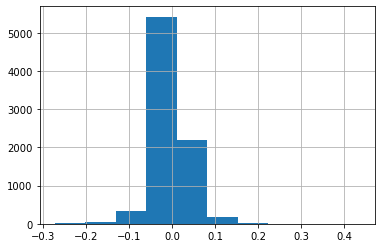

In [199]:
df['Change'].hist(bins=10)

In [198]:
np.histogram(df['Change'].dropna(), 10)

(array([  14,   45,  327, 5420, 2186,  183,   20,    3,    0,    1]),
 array([-0.27200007, -0.2013001 , -0.13060012, -0.05990014,  0.01079984,
         0.08149981,  0.15219979,  0.22289977,  0.29359975,  0.36429973,
         0.4349997 ]))

In [200]:
df['Change'].describe()

count    8199.000000
mean        0.000323
std         0.037644
min        -0.272000
25%        -0.012000
50%         0.000000
75%         0.014000
max         0.435000
Name: Change, dtype: float64

In [6]:
gs = gsheets.client(gsheets.installed_app_creds('../client_secret_moondatatrader.json'))

In [14]:
doc_config = gs.open('1Rdaq2lDfn6o-G04QEM9KIr3QCiVEN4dEB5X0r1PUi48')
config = doc_config.sheets[0].read()
[row for row in config.rows if row[0] == 'HG.1']

[['HG.1', '1m', '2019-12', '1SwvsS4E1kAM9nbhx0Pl0e2oyIs8KX2oQjCgLgr0xsDc'],
 ['HG.1', '1m', '2020-01', '1bUcWNIhgGxHZdvyrzAgjPwvRsoY4LbuqCBeVQtW_m8A'],
 ['HG.1', '1m', '2020-02', '1MezoFPr1COLNXlmuO2Vf_cQWvCfTKSpVfjURWgYzoi8'],
 ['HG.1', '1m', '2020-03', '1PdBkz42WHvxu97xqXvzpPKYiQ0lSx9kPca5WmeI82Qs'],
 ['HG.1', '30m', '2016', '1nDxmVQof-frdP5IvTxDrwtujUYLAUTxkMnN7rqQmtzo'],
 ['HG.1', '30m', '2017', '1kPAuSogIssFGkSYZUcxeTdVRdSomdLq8iqTG_B3y_EE'],
 ['HG.1', '30m', '2018', '14F3uGkYqW2XVO3qWWrfZ_0QLDC3IRVwQfRc2bowYPxE'],
 ['HG.1', '30m', '2019', '1x3PDdkXAumOVnM9oqtZDqzH_C2EGvXQOtqFlNhu-AVE'],
 ['HG.1', '30m', '2020', '1lKMqhluf3DZLQ22kpjFB2ZdEHc4KzLlqWdrb-iKN31w'],
 ['HG.1', '30m', '2021', '1xGdrEt9pgfH81lR5d2aIqi9vzoZsp5ZvmnM9FwIPO2I']]

In [83]:
df = sheet_df('1lKMqhluf3DZLQ22kpjFB2ZdEHc4KzLlqWdrb-iKN31w')

In [93]:
candlestick(df['2020-12-01 23:00:00':'2020-12-30 23:30:00'])

In [7]:
doc_id = gs.create('구리 월물')
sheet = gs.open(doc_id).sheets[0].read()
sheet.set_headers(['Date', 'Open', 'High', 'Low', 'Close'])
under_dot = 4
for row in df.iterrows():
    sheet.rows.append([row[0].strftime('%Y-%m-%d'), round(row[1][0],under_dot), round(row[1][1],under_dot), round(row[1][2],under_dot), round(row[1][3],under_dot)])
sheet.write()

In [139]:
for row in df.iterrows():
    print(row[0].strftime('%Y-%m-%d'), round(row[1][0], 4))

1988-07-29 0.906
1988-08-01 0.891
1988-08-02 0.88
1988-08-03 0.888
1988-08-04 0.903
1988-08-05 0.912
1988-08-08 0.896
1988-08-09 0.898
1988-08-10 0.91
1988-08-11 0.93
1988-08-12 0.918
1988-08-15 0.92
1988-08-16 0.918
1988-08-17 0.925
1988-08-18 0.957
1988-08-19 0.962
1988-08-22 0.986
1988-08-23 0.983
1988-08-24 0.989
1988-08-25 0.999
1988-08-26 1.008
1988-08-29 1.005
1988-08-30 1.0
1988-08-31 1.012
1988-09-01 0.99
1988-09-02 0.986
1988-09-06 0.991
1988-09-07 0.993
1988-09-08 1.0
1988-09-09 1.012
1988-09-12 1.017
1988-09-13 1.039
1988-09-14 1.035
1988-09-15 1.044
1988-09-16 1.037
1988-09-19 1.031
1988-09-20 1.032
1988-09-21 1.009
1988-09-22 1.037
1988-09-23 1.06
1988-09-26 1.058
1988-09-27 1.079
1988-09-28 1.067
1988-09-29 1.088
1988-09-30 1.088
1988-10-03 1.086
1988-10-04 1.093
1988-10-05 1.099
1988-10-06 1.123
1988-10-07 1.137
1988-10-10 1.167
1988-10-11 1.187
1988-10-12 1.183
1988-10-13 1.179
1988-10-14 1.232
1988-10-17 1.22
1988-10-18 1.252
1988-10-19 1.297
1988-10-20 1.323
1988-10-

1991-09-30 1.093
1991-10-01 1.073
1991-10-02 1.086
1991-10-03 1.082
1991-10-04 1.084
1991-10-07 1.071
1991-10-08 1.067
1991-10-09 1.08
1991-10-10 1.077
1991-10-11 1.058
1991-10-14 1.067
1991-10-15 1.054
1991-10-16 1.064
1991-10-17 1.067
1991-10-18 1.07
1991-10-21 1.059
1991-10-22 1.063
1991-10-23 1.066
1991-10-24 1.071
1991-10-25 1.061
1991-10-28 1.062
1991-10-29 1.078
1991-10-30 1.08
1991-10-31 1.075
1991-11-01 1.065
1991-11-04 1.07
1991-11-05 1.068
1991-11-06 1.063
1991-11-07 1.06
1991-11-08 1.062
1991-11-11 1.05
1991-11-12 1.048
1991-11-13 1.051
1991-11-14 1.056
1991-11-15 1.064
1991-11-18 1.058
1991-11-19 1.049
1991-11-20 1.042
1991-11-21 1.042
1991-11-22 1.038
1991-11-25 1.034
1991-11-26 1.052
1991-11-27 1.046
1991-11-29 1.028
1991-12-02 1.027
1991-12-03 1.012
1991-12-04 1.013
1991-12-05 1.003
1991-12-06 0.988
1991-12-09 0.985
1991-12-10 0.977
1991-12-11 0.979
1991-12-12 0.985
1991-12-13 0.976
1991-12-16 0.973
1991-12-17 0.977
1991-12-18 0.981
1991-12-19 0.985
1991-12-20 0.974
199

1994-05-04 0.933
1994-05-05 0.923
1994-05-06 0.94
1994-05-09 0.951
1994-05-10 0.975
1994-05-11 0.985
1994-05-12 0.985
1994-05-13 1.008
1994-05-16 1.027
1994-05-17 1.038
1994-05-18 1.025
1994-05-19 1.058
1994-05-20 1.033
1994-05-23 1.039
1994-05-24 1.068
1994-05-25 1.057
1994-05-26 1.036
1994-05-27 1.036
1994-05-31 1.042
1994-06-01 1.022
1994-06-02 1.008
1994-06-03 1.031
1994-06-06 1.026
1994-06-07 1.021
1994-06-08 1.076
1994-06-09 1.093
1994-06-10 1.086
1994-06-13 1.115
1994-06-14 1.094
1994-06-15 1.099
1994-06-16 1.112
1994-06-17 1.119
1994-06-20 1.11
1994-06-21 1.117
1994-06-22 1.129
1994-06-23 1.137
1994-06-24 1.121
1994-06-27 1.098
1994-06-28 1.075
1994-06-29 1.061
1994-06-30 1.066
1994-07-01 1.083
1994-07-05 1.119
1994-07-06 1.109
1994-07-07 1.077
1994-07-08 1.095
1994-07-11 1.096
1994-07-12 1.096
1994-07-13 1.102
1994-07-14 1.11
1994-07-15 1.119
1994-07-18 1.118
1994-07-19 1.115
1994-07-20 1.153
1994-07-21 1.144
1994-07-22 1.14
1994-07-25 1.143
1994-07-26 1.143
1994-07-27 1.088
1

1996-09-23 0.887
1996-09-24 0.883
1996-09-25 0.905
1996-09-26 0.912
1996-09-27 0.933
1996-09-30 0.91
1996-10-01 0.892
1996-10-02 0.885
1996-10-03 0.898
1996-10-04 0.901
1996-10-07 0.902
1996-10-08 0.9
1996-10-09 0.91
1996-10-10 0.918
1996-10-11 0.932
1996-10-14 0.924
1996-10-15 0.915
1996-10-16 0.917
1996-10-17 0.909
1996-10-18 0.928
1996-10-21 0.937
1996-10-22 0.951
1996-10-23 0.966
1996-10-24 0.965
1996-10-25 0.989
1996-10-28 1.005
1996-10-29 0.99
1996-10-30 0.908
1996-10-31 0.931
1996-11-01 0.925
1996-11-04 0.933
1996-11-05 0.938
1996-11-06 0.93
1996-11-07 0.932
1996-11-08 0.967
1996-11-11 0.962
1996-11-12 0.965
1996-11-13 0.98
1996-11-14 0.965
1996-11-15 0.967
1996-11-18 1.025
1996-11-19 1.065
1996-11-20 1.071
1996-11-21 1.062
1996-11-22 1.052
1996-11-25 1.039
1996-11-26 1.06
1996-11-27 1.084
1996-12-02 1.092
1996-12-03 1.055
1996-12-04 1.054
1996-12-05 1.052
1996-12-06 1.041
1996-12-09 1.041
1996-12-10 1.03
1996-12-11 1.043
1996-12-12 1.028
1996-12-13 1.026
1996-12-16 1.018
1996-1

1999-09-17 0.828
1999-09-20 0.828
1999-09-21 0.822
1999-09-22 0.825
1999-09-23 0.815
1999-09-24 0.803
1999-09-27 0.804
1999-09-28 0.789
1999-09-29 0.82
1999-09-30 0.801
1999-10-01 0.809
1999-10-04 0.805
1999-10-05 0.801
1999-10-06 0.805
1999-10-07 0.795
1999-10-08 0.79
1999-10-11 0.756
1999-10-12 0.767
1999-10-13 0.79
1999-10-14 0.777
1999-10-15 0.777
1999-10-18 0.777
1999-10-19 0.787
1999-10-20 0.801
1999-10-21 0.806
1999-10-22 0.808
1999-10-25 0.809
1999-10-26 0.796
1999-10-27 0.793
1999-10-28 0.79
1999-10-29 0.806
1999-11-01 0.805
1999-11-02 0.809
1999-11-03 0.808
1999-11-04 0.82
1999-11-05 0.801
1999-11-08 0.795
1999-11-09 0.798
1999-11-10 0.798
1999-11-11 0.792
1999-11-12 0.779
1999-11-15 0.767
1999-11-16 0.778
1999-11-17 0.785
1999-11-18 0.78
1999-11-19 0.783
1999-11-22 0.784
1999-11-23 0.785
1999-11-24 0.786
1999-11-29 0.791
1999-11-30 0.795
1999-12-01 0.79
1999-12-02 0.787
1999-12-03 0.783
1999-12-06 0.8
1999-12-07 0.803
1999-12-08 0.787
1999-12-09 0.79
1999-12-10 0.788
1999-12

2002-02-19 0.721
2002-02-20 0.702
2002-02-21 0.713
2002-02-22 0.699
2002-02-25 0.705
2002-02-26 0.709
2002-02-27 0.702
2002-02-28 0.718
2002-03-01 0.715
2002-03-04 0.736
2002-03-05 0.738
2002-03-06 0.734
2002-03-07 0.74
2002-03-08 0.742
2002-03-11 0.747
2002-03-12 0.738
2002-03-13 0.735
2002-03-14 0.736
2002-03-15 0.747
2002-03-18 0.761
2002-03-19 0.766
2002-03-20 0.762
2002-03-21 0.759
2002-03-22 0.757
2002-03-25 0.737
2002-03-26 0.74
2002-03-27 0.747
2002-03-28 0.753
2002-04-01 0.76
2002-04-02 0.765
2002-04-03 0.75
2002-04-04 0.733
2002-04-05 0.733
2002-04-08 0.724
2002-04-09 0.721
2002-04-10 0.72
2002-04-11 0.722
2002-04-12 0.716
2002-04-15 0.71
2002-04-16 0.723
2002-04-17 0.731
2002-04-18 0.731
2002-04-19 0.73
2002-04-22 0.746
2002-04-23 0.735
2002-04-24 0.73
2002-04-25 0.726
2002-04-26 0.731
2002-04-29 0.732
2002-04-30 0.732
2002-05-01 0.733
2002-05-02 0.72
2002-05-03 0.728
2002-05-06 0.716
2002-05-07 0.71
2002-05-08 0.721
2002-05-09 0.728
2002-05-10 0.726
2002-05-13 0.73
2002-05-

2004-09-14 1.275
2004-09-15 1.278
2004-09-16 1.28
2004-09-17 1.3
2004-09-20 1.3
2004-09-21 1.311
2004-09-22 1.345
2004-09-23 1.362
2004-09-24 1.366
2004-09-27 1.376
2004-09-28 1.379
2004-09-29 1.377
2004-09-30 1.391
2004-10-01 1.401
2004-10-04 1.386
2004-10-05 1.402
2004-10-06 1.418
2004-10-07 1.428
2004-10-08 1.469
2004-10-11 1.477
2004-10-12 1.438
2004-10-13 1.328
2004-10-14 1.296
2004-10-15 1.308
2004-10-18 1.31
2004-10-19 1.306
2004-10-20 1.306
2004-10-21 1.316
2004-10-22 1.3
2004-10-25 1.287
2004-10-26 1.288
2004-10-27 1.293
2004-10-28 1.265
2004-10-29 1.26
2004-11-01 1.323
2004-11-02 1.31
2004-11-03 1.34
2004-11-04 1.353
2004-11-05 1.368
2004-11-08 1.391
2004-11-09 1.375
2004-11-10 1.387
2004-11-11 1.39
2004-11-12 1.408
2004-11-15 1.433
2004-11-16 1.416
2004-11-17 1.456
2004-11-18 1.47
2004-11-19 1.482
2004-11-22 1.459
2004-11-23 1.465
2004-11-24 1.492
2004-11-29 1.428
2004-11-30 1.44
2004-12-01 1.445
2004-12-02 1.462
2004-12-03 1.44
2004-12-06 1.425
2004-12-07 1.429
2004-12-08 1

2006-09-22 3.478
2006-09-25 3.379
2006-09-26 3.45
2006-09-27 3.466
2006-09-28 3.47
2006-09-29 3.395
2006-10-02 3.47
2006-10-03 3.416
2006-10-04 3.276
2006-10-05 3.295
2006-10-06 3.33
2006-10-09 3.415
2006-10-10 3.375
2006-10-11 3.39
2006-10-12 3.37
2006-10-13 3.425
2006-10-16 3.485
2006-10-17 3.5
2006-10-18 3.484
2006-10-19 3.475
2006-10-20 3.489
2006-10-23 3.43
2006-10-24 3.38
2006-10-25 3.375
2006-10-26 3.36
2006-10-27 3.378
2006-10-30 3.395
2006-10-31 3.33
2006-11-01 3.336
2006-11-02 3.25
2006-11-03 3.3
2006-11-06 3.29
2006-11-07 3.4
2006-11-08 3.296
2006-11-09 3.27
2006-11-10 3.195
2006-11-13 3.11
2006-11-14 3.07
2006-11-15 3.06
2006-11-16 3.078
2006-11-17 3.0
2006-11-20 3.065
2006-11-21 3.087
2006-11-22 3.145
2006-11-23 3.145
2006-11-24 3.106
2006-11-27 3.185
2006-11-28 3.186
2006-11-29 3.145
2006-11-30 3.129
2006-12-01 3.17
2006-12-04 3.147
2006-12-05 3.163
2006-12-06 3.228
2006-12-07 3.149
2006-12-08 3.11
2006-12-11 3.119
2006-12-12 3.13
2006-12-13 3.083
2006-12-14 3.042
2006-12

2009-09-14 2.8
2009-09-15 2.806
2009-09-16 2.849
2009-09-17 2.917
2009-09-18 2.88
2009-09-21 2.755
2009-09-22 2.81
2009-09-23 2.812
2009-09-24 2.76
2009-09-25 2.662
2009-09-28 2.7
2009-09-29 2.698
2009-09-30 2.735
2009-10-01 2.797
2009-10-02 2.7
2009-10-05 2.68
2009-10-06 2.718
2009-10-07 2.761
2009-10-08 2.832
2009-10-09 2.848
2009-10-12 2.83
2009-10-13 2.817
2009-10-14 2.813
2009-10-15 2.788
2009-10-16 2.833
2009-10-19 2.81
2009-10-20 2.922
2009-10-21 2.904
2009-10-22 2.975
2009-10-23 3.031
2009-10-26 3.047
2009-10-27 2.96
2009-10-28 2.995
2009-10-29 2.909
2009-10-30 2.99
2009-11-02 2.96
2009-11-03 2.922
2009-11-04 2.982
2009-11-05 2.96
2009-11-06 2.935
2009-11-09 2.986
2009-11-10 2.95
2009-11-11 3.007
2009-11-12 2.937
2009-11-13 2.952
2009-11-16 3.017
2009-11-17 3.075
2009-11-18 3.091
2009-11-19 3.09
2009-11-20 3.082
2009-11-23 3.155
2009-11-24 3.12
2009-11-25 3.136
2009-11-27 3.175
2009-11-30 3.095
2009-12-01 3.155
2009-12-02 3.188
2009-12-03 3.233
2009-12-04 3.21
2009-12-07 3.195


2011-09-06 4.08
2011-09-07 4.065
2011-09-08 4.103
2011-09-09 4.08
2011-09-12 3.966
2011-09-13 4.006
2011-09-14 3.94
2011-09-15 3.894
2011-09-16 3.97
2011-09-19 3.861
2011-09-20 3.756
2011-09-21 3.726
2011-09-22 3.692
2011-09-23 3.397
2011-09-26 3.241
2011-09-27 3.45
2011-09-28 3.358
2011-09-29 3.155
2011-09-30 3.183
2011-10-03 3.072
2011-10-04 3.088
2011-10-05 3.116
2011-10-06 3.231
2011-10-07 3.313
2011-10-10 3.366
2011-10-11 3.264
2011-10-12 3.3
2011-10-13 3.3
2011-10-14 3.39
2011-10-17 3.454
2011-10-18 3.313
2011-10-19 3.29
2011-10-20 3.19
2011-10-21 3.219
2011-10-24 3.357
2011-10-25 3.482
2011-10-26 3.572
2011-10-27 3.689
2011-10-28 3.628
2011-10-31 3.69
2011-11-01 3.56
2011-11-02 3.591
2011-11-03 3.472
2011-11-04 3.575
2011-11-07 3.548
2011-11-08 3.559
2011-11-09 3.564
2011-11-10 3.354
2011-11-11 3.394
2011-11-14 3.517
2011-11-15 3.466
2011-11-16 3.499
2011-11-17 3.462
2011-11-18 3.381
2011-11-21 3.369
2011-11-22 3.345
2011-11-23 3.252
2011-11-25 3.272
2011-11-28 3.358
2011-11-29 

2013-08-08 3.248
2013-08-09 3.265
2013-08-12 3.329
2013-08-13 3.325
2013-08-14 3.316
2013-08-15 3.325
2013-08-16 3.354
2013-08-19 3.343
2013-08-20 3.32
2013-08-21 3.328
2013-08-22 3.365
2013-08-23 3.35
2013-08-26 3.374
2013-08-27 3.36
2013-08-28 3.31
2013-08-29 3.304
2013-08-30 3.237
2013-09-03 3.25
2013-09-04 3.297
2013-09-05 3.24
2013-09-06 3.24
2013-09-09 3.258
2013-09-10 3.26
2013-09-11 3.268
2013-09-12 3.272
2013-09-13 3.201
2013-09-16 3.27
2013-09-17 3.231
2013-09-18 3.22
2013-09-19 3.325
2013-09-20 3.345
2013-09-23 3.283
2013-09-24 3.293
2013-09-25 3.273
2013-09-26 3.304
2013-09-27 3.299
2013-09-30 3.293
2013-10-01 3.318
2013-10-02 3.268
2013-10-03 3.304
2013-10-04 3.264
2013-10-07 3.272
2013-10-08 3.287
2013-10-09 3.283
2013-10-10 3.225
2013-10-11 3.245
2013-10-14 3.306
2013-10-15 3.3
2013-10-16 3.26
2013-10-17 3.28
2013-10-18 3.285
2013-10-21 3.299
2013-10-22 3.31
2013-10-23 3.32
2013-10-24 3.261
2013-10-25 3.245
2013-10-28 3.269
2013-10-29 3.281
2013-10-30 3.273
2013-10-31 3.

2015-09-02 2.295
2015-09-03 2.336
2015-09-04 2.37
2015-09-08 2.326
2015-09-09 2.434
2015-09-10 2.43
2015-09-11 2.463
2015-09-14 2.442
2015-09-15 2.42
2015-09-16 2.43
2015-09-17 2.463
2015-09-18 2.47
2015-09-21 2.385
2015-09-22 2.39
2015-09-23 2.303
2015-09-24 2.316
2015-09-25 2.309
2015-09-28 2.29
2015-09-29 2.24
2015-09-30 2.263
2015-10-01 2.341
2015-10-02 2.3
2015-10-05 2.354
2015-10-06 2.357
2015-10-07 2.364
2015-10-08 2.37
2015-10-09 2.352
2015-10-12 2.435
2015-10-13 2.397
2015-10-14 2.403
2015-10-15 2.423
2015-10-16 2.433
2015-10-19 2.397
2015-10-20 2.364
2015-10-21 2.35
2015-10-22 2.363
2015-10-23 2.377
2015-10-26 2.35
2015-10-27 2.37
2015-10-28 2.346
2015-10-29 2.334
2015-10-30 2.321
2015-11-02 2.291
2015-11-03 2.308
2015-11-04 2.337
2015-11-05 2.28
2015-11-06 2.264
2015-11-09 2.238
2015-11-10 2.217
2015-11-11 2.213
2015-11-12 2.2
2015-11-13 2.166
2015-11-16 2.16
2015-11-17 2.12
2015-11-18 2.088
2015-11-19 2.079
2015-11-20 2.095
2015-11-23 2.013
2015-11-24 2.023
2015-11-25 2.045

2019-04-17 2.98
2019-04-18 2.978
2019-04-19 2.918
2019-04-22 2.9345
2019-04-23 2.9235
2019-04-24 2.956
2019-04-25 2.9355
2019-04-26 2.926
2019-04-29 2.91
2019-04-30 2.939
2019-05-01 2.939
2019-05-02 2.827
2019-05-03 2.816
2019-05-06 2.8605
2019-05-07 2.856
2019-05-08 2.8135
2019-05-09 2.803
2019-05-10 2.7935
2019-05-13 2.7685
2019-05-14 2.7495
2019-05-15 2.7445
2019-05-16 2.754
2019-05-17 2.7755
2019-05-20 2.766
2019-05-21 2.752
2019-05-22 2.7305
2019-05-23 2.694
2019-05-24 2.7415
2019-05-26 2.699
2019-05-27 2.7
2019-05-28 2.7315
2019-05-29 2.7
2019-05-30 2.673
2019-05-31 2.6475
2019-06-03 2.639
2019-06-04 2.676
2019-06-05 2.6985
2019-06-06 2.6585
2019-06-07 2.67
2019-06-10 2.651
2019-06-11 2.6975
2019-06-12 2.67
2019-06-13 2.656
2019-06-14 2.6555
2019-06-17 2.668
2019-06-18 2.66
2019-06-19 2.6965
2019-06-20 2.7345
2019-06-21 2.73
2019-06-24 2.7175
2019-06-25 2.7345
2019-06-26 2.7425
2019-06-27 2.746
2019-06-28 2.7485
2019-07-01 2.7685
2019-07-02 2.6985
2019-07-03 2.667
2019-07-04 2.68

In [123]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [10]:
targets = [
    ['삼성전자', 43433],
    ['SK하이닉스', 43430],
    ['네이버', 43493]
]

In [11]:
df_list = [history(ticker, 'D', '2019-01-01')['Close'] for name, ticker in targets]
df = pd.concat(df_list, axis=1)
df.columns = [name for name, ticker in targets] 
df.tail(10)

,삼성전자,SK하이닉스,네이버
Date,,,
2021-01-19 09:00:00,87000.0,130500.0,308000.0
2021-01-20 09:00:00,87200.0,130500.0,308000.0
2021-01-21 09:00:00,88100.0,131500.0,322500.0
2021-01-22 09:00:00,86800.0,128500.0,343500.0
2021-01-24 09:00:00,86800.0,128500.0,343500.0
2021-01-25 09:00:00,89400.0,135000.0,349000.0
2021-01-26 09:00:00,86700.0,129000.0,342000.0
2021-01-27 09:00:00,85600.0,128500.0,341500.0
2021-01-28 09:00:00,83700.0,123000.0,355000.0


In [12]:
df_plot = df / df.iloc[0] - 1.0
df_plot.iplot()

In [13]:
fdr.DataReader('005930')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-02-18,996,1028,987,1012,164930,NaN
1997-02-19,1013,1024,1004,1023,104330,0.010870
1997-02-20,1013,1031,999,1007,88710,-0.015640
1997-02-21,996,1004,933,943,143230,-0.063555
1997-02-22,933,969,916,966,124900,0.024390
...,...,...,...,...,...,...
2021-01-25,87000,89900,86300,89400,27258534,0.029954
2021-01-26,88800,89200,86500,86700,33178936,-0.030201
2021-01-27,86600,87700,85600,85600,26423070,-0.012687


In [7]:
fdr.DataReader('AAPL', '2017')

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092
...,...,...,...,...,...,...
2020-10-02,113.02,112.89,115.37,112.22,144710000.0,-0.0323
2020-10-05,116.50,113.91,116.65,113.55,106240000.0,0.0308
2020-10-06,113.16,115.80,116.09,112.30,161500000.0,-0.0287


In [8]:
fdr.DataReader('7203', '2020-01-01', exchange='TSE') # 소프트뱅크그룹(7203)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-06,7565.0,7599.0,7626.0,7530.0,6670000.0,-0.0193
2020-01-07,7715.0,7654.0,7722.0,7619.0,4960000.0,0.0198
2020-01-08,7617.0,7565.0,7642.0,7541.0,5610000.0,-0.0127
2020-01-09,7670.0,7672.0,7690.0,7638.0,4250000.0,0.0070
2020-01-10,7661.0,7695.0,7698.0,7651.0,3480000.0,-0.0012
...,...,...,...,...,...,...
2020-10-05,6909.0,6978.0,6983.0,6886.0,4030000.0,0.0026
2020-10-06,6958.0,6909.0,6984.0,6887.0,4710000.0,0.0071
2020-10-07,7003.0,6928.0,7003.0,6904.0,4250000.0,0.0065


In [9]:
fdr.DataReader('ZG')

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1979-12-27,515.50,517.00,517.00,513.00,0.0,0.0182
1979-12-28,517.80,516.00,517.80,510.40,0.0,0.0045
1979-12-31,533.60,527.88,534.50,527.88,0.0,0.0305
1980-01-02,575.50,562.50,577.00,558.00,7260.0,0.0785
1980-01-03,625.00,627.00,640.00,603.00,20750.0,0.0860
...,...,...,...,...,...,...
2020-10-05,1920.10,1910.90,1924.90,1891.20,177590.0,0.0066
2020-10-06,1908.80,1917.80,1927.00,1878.20,219440.0,-0.0059
2020-10-07,1890.80,1882.60,1902.40,1877.10,188590.0,-0.0094


In [10]:
fdr.StockListing('KRX')

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,이현우,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...,...
2577,000547,KOSPI,흥국화재2우B,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2578,000545,KOSPI,흥국화재우,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2579,003280,KOSPI,흥아해운,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
2580,037440,KOSDAQ,희림,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호, 염두성 (각자대표)",http://www.heerim.com,서울특별시


In [11]:
fdr.StockListing('S&P500')

,Symbol,Name,Sector,Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services
...,...,...,...,...
500,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants
501,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments
502,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment
503,ZION,Zions Bancorp,Financials,Regional Banks


In [13]:
fdr.DataReader(['HSN1F', 'NASDAQCOM', 'M2'], data_source='fred') # HSN1F 주택판매지수, NASDAQCOM 나스닥종합지수 

,NASDAQCOM,HSN1F,M2
DATE,,,
1970-01-01,NaN,461.0,NaN
1970-02-01,NaN,373.0,NaN
1970-03-01,NaN,389.0,NaN
1970-04-01,NaN,445.0,NaN
1970-05-01,NaN,466.0,NaN
...,...,...,...
2020-10-02,11075.016000,1011.0,18652.6
2020-10-05,11332.484000,1011.0,18652.6
2020-10-06,11154.605000,1011.0,18652.6
